In [1]:
from fastai.vision import *

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()

In [3]:
class DetectVisibleInstuctor(cs.BaseInstructor):
    def __init__(self, n_inst, thresh):
        self.n_inst = n_inst
        self.thresh = thresh
        
    def on_batch_begin(self, last_target, train, **kwargs):
        if train:
            self.gt_visible = last_target[..., 2]
            self.train = True
        else:
            self.train = False
            
    def next_inst(self, bu_out):
        state = {'continue': False}
        if self.train:
            return self.gt_visible.clamp(0, 1), state
        inst = torch.where(bu_out.sigmoid() > self.thresh, bu_out.new_ones(1), bu_out.new_zeros(1))
        return inst, state


def loss(outputs, targets, alpha=1):
    bu, td = outputs
    is_visible = targets[..., 2] > 0
    bu_loss = F.binary_cross_entropy_with_logits(bu, is_visible.float())
    
    gt = targets[is_visible][..., :2]
    td_loss = pose.ce_loss(td[is_visible], gt)
    return bu_loss * alpha + td_loss

thresh = 0.75
pckh = partial(pose.Pckh, acc_thresh=thresh)

In [4]:
data = pose.get_data(root, size=128)
data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [5]:
nk = 16

instructor = DetectVisibleInstuctor(nk, thresh)
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=16, bu_c=nk, td_laterals=False, embedding=nn.Linear,
                        loss_func=loss, callback_fns=pckh, pretrained=False)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,acc@0.75,TP_acc,FN_acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 3.63E-02


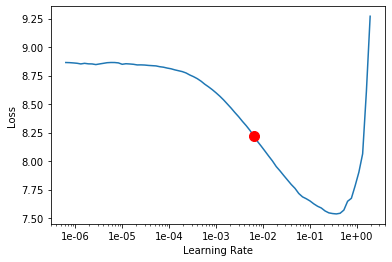

In [12]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [16]:
learner.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,acc@0.75,TP_acc,FN_acc,time
0,5.258880,5.238818,0.616577,0.425406,0.247775,0.256673,0.250723,0.198625,0.310578,0.352674,0.337016,0.733563,0.396975,0.153875,01:12
1,4.825986,4.541855,0.749485,0.555815,0.381089,0.345111,0.355377,0.324395,0.400283,0.471989,0.453267,0.837306,0.490282,0.209324,01:05
2,4.558010,5.752301,0.651453,0.446604,0.234011,0.265727,0.202629,0.182321,0.238923,0.348587,0.328199,0.511056,0.528494,0.131987,01:06
3,4.425104,4.505525,0.762518,0.613768,0.408533,0.385079,0.353998,0.367896,0.416124,0.498952,0.481470,0.827688,0.527113,0.186913,01:05
4,4.278896,4.108345,0.812539,0.683231,0.519109,0.474131,0.436653,0.413422,0.390346,0.568058,0.545778,0.832650,0.589692,0.253310,01:05
5,4.194375,4.222910,0.792499,0.663179,0.501726,0.467273,0.424178,0.406008,0.452053,0.557445,0.539587,0.749563,0.612800,0.286544,01:05
6,4.077827,4.152176,0.799660,0.676597,0.528696,0.483878,0.434025,0.464925,0.482112,0.576796,0.561484,0.802475,0.631062,0.207322,01:05
7,4.009140,4.145420,0.808160,0.683083,0.504519,0.506843,0.436898,0.465059,0.478732,0.579742,0.563649,0.776194,0.650318,0.215437,01:05
8,3.978401,4.054680,0.807387,0.656575,0.545129,0.507838,0.429884,0.438212,0.448769,0.577112,0.557945,0.804388,0.621106,0.234684,01:05
9,3.899676,3.759635,0.850968,0.739254,0.622796,0.574492,0.505536,0.502284,0.527766,0.645754,0.627521,0.856675,0.665083,0.295960,01:05


In [17]:
learner.save('multilabelV2-128', return_path=True)

PosixPath('/home/labs/waic/omrik/LIP/models/multilabelV2-128.pth')

In [18]:
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=nk, bu_c=nk, td_laterals=False, embedding=nn.Linear,
                        loss_func=partial(loss, alpha=0.5), callback_fns=pckh, pretrained=False)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,acc@0.75,TP_acc,FN_acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 5.25E-02


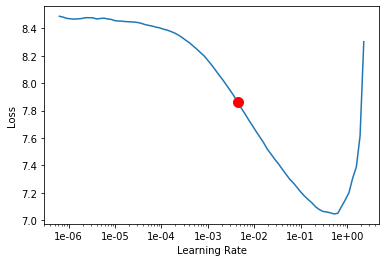

In [19]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

## No Instruction

In [6]:
class NoOpInstuctor(cs.BaseInstructor):
    def __init__(self, n_iter):
        self.n_iter = 0
        
    def next_inst(self, bu_out):
        return None, {'continue': False}

In [7]:
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=nk, bu_c=nk, td_laterals=False, embedding=None,
                        loss_func=loss, callback_fns=pckh, pretrained=False)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,acc@0.75,TP_acc,FN_acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 4.37E-02


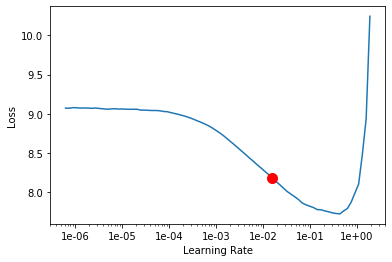

In [8]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [8]:
learner.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,acc@0.75,TP_acc,FN_acc,time
0,5.434390,4.944106,0.668762,0.485189,0.293847,0.264034,0.320343,0.271768,0.394859,0.406218,0.391561,0.673206,0.458319,0.262306,01:17
1,4.982580,4.464206,0.767206,0.575575,0.400898,0.350244,0.381494,0.342021,0.423199,0.492453,0.471559,0.693081,0.537654,0.334165,01:04
2,4.659525,4.281085,0.790130,0.627851,0.450175,0.409228,0.408361,0.410155,0.452746,0.534611,0.515394,0.708350,0.575846,0.369067,01:05
3,4.524731,4.113631,0.793169,0.662171,0.501216,0.447138,0.458220,0.436914,0.476010,0.565660,0.548025,0.770656,0.609969,0.321798,01:05
4,4.384802,3.933520,0.817278,0.688564,0.519195,0.465995,0.485122,0.476905,0.462486,0.586161,0.569189,0.828831,0.604179,0.355746,01:05
5,4.283797,4.012755,0.817226,0.675396,0.514623,0.456357,0.489769,0.478128,0.475094,0.583239,0.567156,0.736325,0.630337,0.382812,01:05
6,4.171737,3.739576,0.839841,0.717969,0.587046,0.516969,0.520978,0.511277,0.504624,0.625462,0.609435,0.839075,0.642962,0.370537,01:05
7,4.123724,3.630241,0.852617,0.737431,0.606508,0.546821,0.531444,0.544702,0.534988,0.645471,0.630954,0.882200,0.646241,0.403475,01:04
8,4.057663,3.732334,0.845508,0.738153,0.596570,0.550173,0.522875,0.531415,0.517687,0.638848,0.624088,0.815269,0.664467,0.379054,01:04
9,4.005356,3.613974,0.854059,0.748652,0.614122,0.569140,0.550186,0.550365,0.565915,0.657591,0.644240,0.842588,0.677323,0.387046,01:05


In [12]:
learner.save('multibale-noinst-128')

In [11]:
learner.data = pose.get_data(root, size=256)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,acc@0.75,TP_acc,FN_acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-03


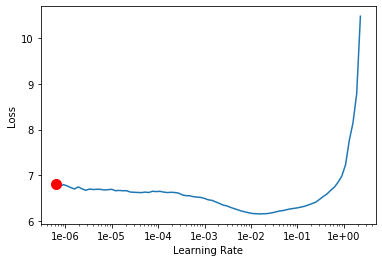

In [13]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
learner.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,acc@0.75,TP_acc,FN_acc,time
0,5.314116,4.619473,0.896353,0.830680,0.722579,0.689498,0.557637,0.565457,0.515300,0.717629,0.695723,0.857456,0.717076,0.433530,01:48
1,4.965169,4.411622,0.902792,0.842326,0.749874,0.716992,0.583669,0.611031,0.567536,0.740376,0.722024,0.861637,0.743669,0.441355,01:48
2,4.842433,4.298980,0.906810,0.851150,0.762687,0.730725,0.602101,0.643750,0.603167,0.754397,0.738735,0.876319,0.756036,0.444060,01:48
3,4.751953,4.221766,0.911859,0.856840,0.773676,0.743816,0.618092,0.669677,0.638623,0.766865,0.753494,0.876313,0.770587,0.463880,01:48
4,4.660281,4.156660,0.915619,0.861905,0.781086,0.752835,0.632337,0.688285,0.661330,0.775975,0.764262,0.893288,0.775508,0.463346,01:47
5,4.586566,4.122068,0.916289,0.866813,0.788344,0.758721,0.641617,0.699735,0.682101,0.782482,0.772173,0.891144,0.782632,0.487181,01:48
6,4.532467,4.086003,0.917731,0.869737,0.795929,0.765307,0.650463,0.708773,0.695658,0.787849,0.778898,0.899325,0.785465,0.491174,01:48
7,4.490276,4.062320,0.922368,0.872555,0.798110,0.769748,0.655052,0.720620,0.705494,0.792125,0.784307,0.891550,0.792313,0.510619,01:48
8,4.439030,4.047712,0.921337,0.873133,0.801297,0.770163,0.659618,0.725489,0.711339,0.794017,0.786694,0.903919,0.789975,0.509858,01:48
9,4.401271,4.038747,0.922728,0.875219,0.802128,0.773410,0.663557,0.727043,0.713894,0.796249,0.788917,0.897713,0.795268,0.513107,01:48
